# GP interpolation of radar freeboard (full and sparse GPs)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import matplotlib as mpl
from scipy.spatial.distance import squareform,pdist,cdist
import scipy.optimize
from netCDF4 import Dataset
from scipy.interpolate import griddata
import pickle
from numpy.linalg import multi_dot as mdot
import glob
import datetime

%matplotlib inline

def grid_proj(lon_0=0,boundinglat=60,llcrnrlon=False,llcrnrlat=False,urcrnrlon=False,urcrnrlat=False):
    import pyproj as proj
    if any([llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat]):
        p = proj.Proj('+proj=stere +R=6370997.0 +units=m +lon_0='+str(float(lon_0))+' +lat_0=90.0',\
                      preserve_units=True)
        llcrnrx,llcrnry = p(llcrnrlon,llcrnrlat)
        p = proj.Proj('+proj=stere +R=6370997.0 +units=m +lon_0='+str(float(lon_0))+' +lat_0=90.0 +x_0='\
                      +str(-llcrnrx)+' +y_0='+str(-llcrnry), preserve_units=True)
    else:
        p = proj.Proj('+proj=stere +R=6370997.0 +units=m +lon_0='+str(float(lon_0))+' +lat_ts=90.0 +lat_0=90.0',\
                      preserve_units=True)
        llcrnrlon = lon_0 - 45
        urcrnrlon = lon_0 + 135
        y_ = p(lon_0,boundinglat)[1]
        llcrnrlat = p(np.sqrt(2.)*y_,0.,inverse=True)[1]
        urcrnrlat = llcrnrlat
        llcrnrx,llcrnry = p(llcrnrlon,llcrnrlat)
        p = proj.Proj('+proj=stere +R=6370997.0 +units=m +lon_0='+str(float(lon_0))+' +lat_ts=90.0 +lat_0=90.0 +x_0='\
                      +str(-llcrnrx)+' +y_0='+str(-llcrnry), preserve_units=True)
    return p

def readFB(grid_res,season):
    """
    Read the input freeboard data (from all satellites) and sea ice extent (sie) mask.
    Returns:
        obs: array containing gridded freeboard information from all satellites
             of size (x,y,n,t), where n is the number of satellites (e.g., CS2 SAR,
             CS2 SARIN, S3A and S3B), and t is the number of days of observations
        sie_mask: array of daily sea ice extent of size (x,y,t), used to determine
                  which grid cells to interpolate to on a given day
        dates_trim: list dates (yyyymmdd) for which there are observations
    """
    f = open(datapath+'/CS2_SAR/CS2_SAR_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    CS2_SAR = pickle.load(f)
    f = open(datapath+'/CS2_SARIN/CS2_SARIN_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    CS2_SARIN = pickle.load(f)
    f = open(datapath+'/S3A/S3A_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    S3A = pickle.load(f)
    f = open(datapath+'/S3B/S3B_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    S3B = pickle.load(f)
    f = open(datapath+'/SIE_masking_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    SIE = pickle.load(f)
    f.close()
    obs = []
    sie = []
    dates = []
    for key in CS2_SAR:
        if (key in CS2_SARIN) & (key in S3A) & (key in S3B):
            obs.append([CS2_SAR[key],CS2_SARIN[key],S3A[key],S3B[key]])
            sie.append(SIE[key])
            dates.append(key)
    obs = np.array(obs).transpose(2,3,1,0)
    sie = np.array(sie).transpose(1,2,0)
    sie[sie<0.15] = np.nan
    return obs,sie,dates

def GPR(x,y,xs,ell,sf2,sn2,mean,approx=False,M=None,returnprior=False):
    """
    Gaussian process regression function to predict radar freeboard
    Inputs:
            x: training data of size n x 3 (3 corresponds to x,y,time)
            y: training outputs of size n x 1 (observations of radar freeboard)
            xs: test inputs of size ns x 3
            ell: correlation length-scales of the covariance function (vector of length 3)
            sf2: scaling pre-factor for covariance function (scalar)
            sn2: noise variance (scalar)
            mean: prior mean (scalar)
            approx: Boolean, whether to use Nyström approximation method
            M: number of training points to use in Nyström approx (integer scalar)
    Returns:
            fs: predictive mean
            sfs2: predictive variance
            np.sqrt(Kxs[0][0]): prior variance
    """
    n = len(y)
    Kxsx = SGPkernel(x,xs=xs,ell=ell,sigma=sf2)
    Kxs = SGPkernel(xs,ell=ell,sigma=sf2)
        
    if approx:
        if M is None:
            M = int(n/5)
        Ki,A = Nystroem(x,y,M=M,ell=ell,sf2=sf2,sn2=sn2)
        err = mdot([Kxsx.T,Ki,Kxsx])
    else:
        Kx = SGPkernel(x,ell=ell,sigma=sf2) + np.eye(n)*sn2
        L = np.linalg.cholesky(Kx)
        A = np.linalg.solve(L.T,np.linalg.solve(L,y))
        v = np.linalg.solve(L,Kxsx)
        err = np.dot(v.T,v)
        
    fs = mean + np.dot(Kxsx.T,A)
    sfs2 = np.sqrt((Kxs - err).diagonal())
    if returnprior:
        return fs,sfs2,np.sqrt(Kxs[0][0])
    else:
        return fs,sfs2

def Nystroem(x,y,M,ell,sf2,sn2,seed=20,opt=False):
    """
    Nyström approximation for kernel machines, e.g., Williams
    and Seeger, 2001. Produce a rank 'M' approximation of K
    and find its inverse via Woodbury identity. This is a 
    faster approach of making predictions, but performance will
    depend on the value of M.
    """
    np.random.seed(seed)
    n = len(y)
    randselect = sorted(np.random.choice(range(n), M, replace=False))
    Kmm = SGPkernel(x[randselect,:],ell=ell,sigma=sf2)
    Knm = SGPkernel(x,xs=x[randselect,:],ell=ell,sigma=sf2)
    Vi = np.eye(n)/sn2

    s,u = np.linalg.eigh(Kmm)
    s[s<=0] = 1e-12
    s_tilde = n*s/M
    u_tilde = np.sqrt(M/n)*np.dot(Knm,u)/s
    L = np.linalg.cholesky(np.diag(1/s_tilde) + mdot([u_tilde.T,Vi,u_tilde]))
    alpha = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(u_tilde.T,Vi)))
    Ki = Vi - mdot([Vi,u_tilde,alpha]) #using Woodbury identity
    if opt:
        L_tilde = np.sqrt(s_tilde)*u_tilde
        det = np.linalg.slogdet(np.eye(M)*sn2 + np.dot(L_tilde.T,L_tilde))
        return Ki,np.atleast_2d(np.dot(Ki,y)).T,(det[0]*det[1])/2
    else:
        return Ki,np.atleast_2d(np.dot(Ki,y)).T
    
def SGPkernel(x,xs=None,grad=False,ell=1,sigma=1):
    """
    Return a Matern (3/2) covariance function for the given inputs.
    Inputs:
            x: training data of size n x 3 (3 corresponds to x,y,time)
            xs: test inputs of size ns x 3
            grad: Boolean whether to return the gradients of the covariance
                  function
            ell: correlation length-scales of the covariance function
            sigma: scaling pre-factor for covariance function
    Returns:
            sigma*k: scaled covariance function
            sigma*dk: scaled matrix of gradients
    """
    if xs is None:
        Q = squareform(pdist(np.sqrt(3.)*x/ell,'euclidean'))
        k = (1 + Q) * np.exp(-Q)
        dk = np.zeros((len(ell),k.shape[0],k.shape[1]))
        for theta in range(len(ell)):
            q = squareform(pdist(np.sqrt(3.)*np.atleast_2d(x[:,theta]/ell[theta]).T,'euclidean'))
            dk[theta,:,:] = q * q * np.exp(-Q)
    else:
        Q = cdist(np.sqrt(3.)*x/ell,np.sqrt(3.)*xs/ell,'euclidean')
        k = (1 + Q) * np.exp(-Q)
    if grad:
        return sigma*k,sigma*dk
    else:
        return sigma*k

def SMLII(hypers,x,y,approx=False,M=None):
    """
    Objective function to minimise when optimising the model
    hyperparameters. This function is the negative log marginal likelihood.
    Inputs:
            hypers: initial guess of hyperparameters
            x: inputs (vector of size n x 3)
            y: outputs (freeboard values from all satellites, size n x 1)
            approx: Boolean, whether to use Nyström approximation method
            M: number of training points to use in Nyström approx (integer scalar)
    Returns:
            nlZ: negative log marginal likelihood
            dnLZ: gradients of the negative log marginal likelihood
    """
    ell = [np.exp(hypers[0]),np.exp(hypers[1]),np.exp(hypers[2])]
    sf2 = np.exp(hypers[3])
    sn2 = np.exp(hypers[4])
    n = len(y)
    Kx,dK = SGPkernel(x,grad=True,ell=ell,sigma=sf2)
    try:
        if approx:
            Ki,A,det = Nystroem(x,y,M=M,ell=ell,sf2=sf2,sn2=sn2,opt=True)
            nlZ = np.dot(y.T,A)/2 + det + n*np.log(2*np.pi)/2
            Q = Ki - np.dot(A,A.T)
        else:
            L = np.linalg.cholesky(Kx + np.eye(n)*sn2)
            A = np.atleast_2d(np.linalg.solve(L.T,np.linalg.solve(L,y))).T
            nlZ = np.dot(y.T,A)/2 + np.log(L.diagonal()).sum() + n*np.log(2*np.pi)/2
            Q = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(n))) - np.dot(A,A.T)
            
        dnlZ = np.zeros(len(hypers))
        for theta in range(len(hypers)):
            if theta < 3:
                dnlZ[theta] = (Q*dK[theta,:,:]).sum()/2
            elif theta == 3:
                dnlZ[theta] = (Q*(2 * Kx)).sum()/2
            elif theta == 4:
                dnlZ[theta] = sn2*np.trace(Q)
    except np.linalg.LinAlgError as e:
        nlZ = np.inf ; dnlZ = np.ones(len(hypers))*np.inf
    return nlZ,dnlZ

    
grid_res = 25 #in km
season = '2018-2019'
datapath = '/Users/williamgregory/Documents/Datasets/Freeboard'
x = np.load(datapath+'/x_'+str(grid_res)+'km.npy') #zonal grid positions
y = np.load(datapath+'/y_'+str(grid_res)+'km.npy') #meridional grid positions
m = grid_proj(lon_0=360)
lon,lat = m(x,y,inverse=True)

T=9 #9 days of data are used to train the model. You could test varying this. Could maybe get away with 5 or 7.
T_mid=T//2 #interpolate on the central day
obs,sie,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]

mplot = grid_proj(llcrnrlon=-90, llcrnrlat=75, urcrnrlon=-152, urcrnrlat=82)
xFB,yFB = mplot(lon,lat) #zonal & meridional positions for new projection

day = 1 #training data starts at day = 11
sie_day = sie[:,:,day+T_mid] #this is the sea ice extent mask on the day we are interpolating (i.e., we need to make sure there is sea ice where we want to estimate freeboard)
sat = obs[:,:,:,day:day+T] #the T days of training data from all satellites
background = np.nanmean(obs[:,:,:,:31],(2,3))
cs2_FYI = np.load(datapath+'/CS2_25km_FYI_20181101-20190428.npy') #this contains a (x,y,t) numpy array of only first-year-ice freeboards. We use this to define the prior mean

if day == 1:
    loc = 7783
elif day == 11:
    loc = 7869

#this next part loops over all T days of training data and appends all the inputs/outputs into long vectors
x1 = [] ; y1 = [] ; t1 = [] ; z1 = []
x2 = [] ; y2 = [] ; t2 = [] ; z2 = []
x3 = [] ; y3 = [] ; t3 = [] ; z3 = []
x4 = [] ; y4 = [] ; t4 = [] ; z4 = []
m1 = [] ; m2 = [] ; m3 = [] ; m4 = []
for dayz in range(sat.shape[3]):
    IDs_1 = np.where(~np.isnan(sat[:,:,0,dayz]))
    IDs_2 = np.where(~np.isnan(sat[:,:,1,dayz]))
    IDs_3 = np.where(~np.isnan(sat[:,:,2,dayz]))
    IDs_4 = np.where(~np.isnan(sat[:,:,3,dayz]))
    x1.extend(xFB[IDs_1]) ; x2.extend(xFB[IDs_2]) ; x3.extend(xFB[IDs_3]) ; x4.extend(xFB[IDs_4])
    y1.extend(yFB[IDs_1]) ; y2.extend(yFB[IDs_2]) ; y3.extend(yFB[IDs_3]) ; y4.extend(yFB[IDs_4])
    t1.extend(np.ones(np.shape(IDs_1)[1])*dayz) ; t2.extend(np.ones(np.shape(IDs_2)[1])*dayz) ; t3.extend(np.ones(np.shape(IDs_3)[1])*dayz) ; t4.extend(np.ones(np.shape(IDs_4)[1])*dayz)
    z1.extend(sat[:,:,0,dayz][IDs_1]) ; z2.extend(sat[:,:,1,dayz][IDs_2]) ; z3.extend(sat[:,:,2,dayz][IDs_3]) ; z4.extend(sat[:,:,3,dayz][IDs_4])
    m1.extend(background[IDs_1]) ; m2.extend(background[IDs_2]) ; m3.extend(background[IDs_3]) ; m4.extend(background[IDs_4])
x_train = np.concatenate((x1,x2,x3,x4))
y_train = np.concatenate((y1,y2,y3,y4))
t_train = np.concatenate((t1,t2,t3,t4))
z = np.concatenate((z1,z2,z3,z4))
prior = np.concatenate((m1,m2,m3,m4))
xy_train = np.array([x_train,y_train]).T

IDs = np.where(~np.isnan(sie_day))
priorXS = background[IDs]
priorXS[(np.isnan(priorXS)) & (lat[IDs]>87)] = np.mean(priorXS[(~np.isnan(priorXS)) & (lat[IDs]>87)])
X = np.array([xFB[IDs],yFB[IDs]]).T
X_tree = scipy.spatial.cKDTree(xy_train)

ID = X_tree.query_ball_point(x=[.94e6,3.5e5],r=300*1000)#X[loc], r=300*1000) #find all training points within 300km radius
inputs = np.array([x_train[ID],y_train[ID],t_train[ID]]).T #training inputs
outputs = z[ID] #training outputs
n = len(outputs)
Xs = np.atleast_2d(np.array([X[loc][0],X[loc][1],T_mid])) #test inputs

/var/folders/hc/38dggdms5_v_dppgp1m80hb00000gn/T/ipykernel_80725/1333303482.py:234: RuntimeWarning: Mean of empty slice
  background = np.nanmean(obs[:,:,:,:31],(2,3))


# GPR example: 1 grid cell (Figure 2 of paper) - CONSTANT PRIOR MEAN

In [2]:
import time
mean = np.nanmean(cs2_FYI[:,:,day+16:day+25]).round(3)
mX = np.ones(n)*mean
t = time.time()
x0 = [np.log(grid_res*1000),np.log(grid_res*1000),np.log(1.),np.log(1.),np.log(.1)] #initial guess of hyperparameters
res = scipy.optimize.minimize(SMLII,x0=x0,args=(inputs,outputs-mX),method='CG',jac=True) #optimise hyperparameters
lx = np.exp(res.x[0]) #zonal correlation length-scale
ly = np.exp(res.x[1]) #meridional correlation length-scale
lt = np.exp(res.x[2]) #temporal correlation length-scale
sf2 = np.exp(res.x[3]) #scaling pre-factor
sn2 = np.exp(res.x[4]) #noise variance
print('hyperparameters:',np.exp(res.x))

fs,σfs,σp = GPR(inputs,outputs-mX,Xs,ell=[lx,ly,lt],\
                sf2=sf2,sn2=sn2,mean=mean,returnprior=True) #prediction mean and variance
marginal_likelihood = -1*SMLII(res.x,inputs,outputs-mX)[0]
print('prediction:',fs,'uncertainty:',σfs,'marginal likelihood:',marginal_likelihood)
print('time taken:',round(time.time()-t,2),'seconds')
fb_values = np.linspace(-.5,.5,500)
prior_pdf = stats.norm.pdf(fb_values, mean, σp)
post = stats.norm.pdf(fb_values, fs, σfs)
"""
fig,ax = plt.subplots(1,figsize=(8,5))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.plot(fb_values,prior_pdf,linewidth=3,color='k',linestyle='--')
ax.plot(fb_values,post,linewidth=3,color='k')
ax.axvline(fs,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)
ax.axvline(mean,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)

ax.fill_between(fb_values,prior_pdf,where=((fb_values>=mean-σp) & \
                                     (fb_values<=mean+σp)),color='k',alpha=.1)
ax.fill_between(fb_values,post,where=((fb_values>=fs-σfs) & \
                                     (fb_values<=fs+σfs)),color='k',alpha=.1)

ax.set_ylim(0,14.5)
ax.set_yticks([])
ax.set_xlabel('Radar freeboard (m)')
plt.show()
"""

hyperparameters: [2.14593266e+05 1.39871909e+05 2.10061317e+01 2.78951364e-02
 3.45728378e-03]
prediction: [0.30722802] uncertainty: [0.03166418] marginal likelihood: [2447.07329892]
time taken: 102.59 seconds


"\nfig,ax = plt.subplots(1,figsize=(8,5))\nax.spines['top'].set_color('none')\nax.spines['right'].set_color('none')\nax.spines['left'].set_color('none')\nax.plot(fb_values,prior_pdf,linewidth=3,color='k',linestyle='--')\nax.plot(fb_values,post,linewidth=3,color='k')\nax.axvline(fs,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)\nax.axvline(mean,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)\n\nax.fill_between(fb_values,prior_pdf,where=((fb_values>=mean-σp) &                                      (fb_values<=mean+σp)),color='k',alpha=.1)\nax.fill_between(fb_values,post,where=((fb_values>=fs-σfs) &                                      (fb_values<=fs+σfs)),color='k',alpha=.1)\n\nax.set_ylim(0,14.5)\nax.set_yticks([])\nax.set_xlabel('Radar freeboard (m)')\nplt.show()\n"

# Sparse Variational GP using GPflow

In [11]:
import tensorflow as tf
import gpflow
from gpflow.config import default_float
from gpflow.utilities import print_summary

def SVGP(x,y,xs,Z,lengthscales=1,kernel_variance=1,noise_variance=None,mean=0,batchsize=None,iterations=10000):
    n = len(y)
    if noise_variance is None:
        noise_variance = 0.1*tf.math.reduce_variance(y)
    # Set up a sparse GP
    kernel = gpflow.kernels.Matern32(lengthscales=lengthscales,variance=kernel_variance)
    meanf = gpflow.mean_functions.Constant(mean)

    gp_sparse = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=meanf,num_data=n)
    gp_sparse.likelihood.variance.assign(noise_variance)
    
    if batchsize is None:
        batchsize = n

    # Set up tensorflow dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((x, y)).repeat().shuffle(n)
    train_iter = iter(train_dataset.batch(batchsize))

    # Set up training loss (ELBO) and optimizer (Adam)
    training_loss = gp_sparse.training_loss_closure(train_iter, compile=True)
   
    optimizer = tf.optimizers.Adam()
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, gp_sparse.trainable_variables)

    # Iterate
    elbo_log = []
    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            elbo_log.append(elbo)
        #if step < 1000:
        #    if step % 100 == 0:
        #        print(f"ELBO at step {step}: {elbo:.2f}")
        #else:
        #    if step % 1000 == 0:
        #        print(f"ELBO at step {step}: {elbo:.2f}")
            
    sparse_mean, sparse_var = gp_sparse.predict_f(xs)
    #print_summary(gp_sparse)
    return sparse_mean, sparse_var, gp_sparse

import time
np.random.seed(2)
mean = np.nanmean(cs2_FYI[:,:,day+16:day+25]).round(3)
mX = np.ones(n)*mean
t = time.time()
lengthscales = [grid_res*1000,grid_res*1000,1]
#M = sorted(np.random.choice(np.arange(n),50,replace=False))
#Z = tf.convert_to_tensor(inputs[M].copy(),dtype=tf.float64)
Z = tf.transpose(tf.convert_to_tensor([np.linspace(np.min(inputs[:,ix]),np.max(inputs[:,ix]),50) for ix in range(3)],dtype=tf.float64))
x_ten = tf.convert_to_tensor(inputs,dtype=tf.float64)
y_ten = tf.convert_to_tensor(np.atleast_2d(outputs).T,dtype=tf.float64)
xs_ten = tf.convert_to_tensor(Xs,dtype=tf.float64)

fs_gpflow, σfs_gpflow, model = SVGP(x_ten,y_ten,xs_ten,Z,lengthscales=lengthscales,kernel_variance=1,\
                                    noise_variance=.1,mean=mean,batchsize=100)
σfs_gpflow = np.sqrt(np.squeeze(σfs_gpflow))
fs_gpflow = np.squeeze(fs_gpflow)
print('prediction:',fs_gpflow,'uncertainty:',σfs_gpflow)#,'marginal likelihood:',marginal_likelihood)
print('time taken:',round(time.time()-t,2),'seconds')

post_gpflow = stats.norm.pdf(fb_values, fs_gpflow, σfs_gpflow)

2022-06-06 11:57:32.788693: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpawcb5rjs.py, line 32)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpawcb5rjs.py, line 32)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-06 11:57:36.603244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


prediction: 0.30020767235379386 uncertainty: 0.03766989602665143
time taken: 20.09 seconds


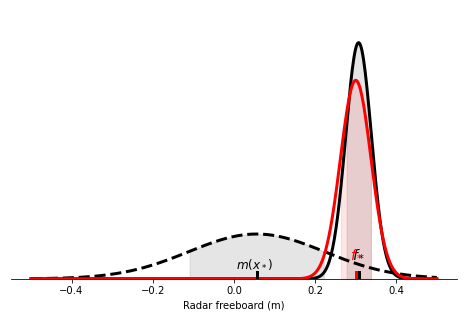

In [12]:
fb_values = np.linspace(-.5,.5,500)
prior_pdf = stats.norm.pdf(fb_values, mean, σp)
post = stats.norm.pdf(fb_values, fs, σfs)

fig,ax = plt.subplots(1,figsize=(8,5))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.plot(fb_values,prior_pdf,linewidth=3,color='k',linestyle='--')
ax.plot(fb_values,post,linewidth=3,color='k')
ax.plot(fb_values,post_gpflow,linewidth=3,color='red')
ax.axvline(fs,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)
ax.axvline(mean,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)

ax.fill_between(fb_values,prior_pdf,where=((fb_values>=mean-σp) & \
                                     (fb_values<=mean+σp)),color='k',alpha=.1)
ax.fill_between(fb_values,post,where=((fb_values>=fs-σfs) & \
                                     (fb_values<=fs+σfs)),color='k',alpha=.1)
ax.axvline(fs_gpflow,ymin=0,ymax=0.025,color='red',linewidth=3,alpha=1)
ax.fill_between(fb_values,post_gpflow,where=((fb_values>=fs_gpflow-σfs_gpflow) & \
                                     (fb_values<=fs_gpflow+σfs_gpflow)),color='red',alpha=.1)
ax.text(mean-.05,0.6,r'$m(x_*)$',fontsize=12)
ax.text(fs-0.015,1.1,'$f_*$',fontsize=14)
ax.text(fs_gpflow-0.015,1.1,'$f_*$',color='red',fontsize=14)

ax.set_ylim(0,14.5)
ax.set_yticks([])
ax.set_xlabel('Radar freeboard (m)')
plt.show()

In [13]:
Z = model.inducing_variable.Z.numpy()
mu = model.q_mu.numpy()
S = np.diag(model.q_sqrt.numpy()[0])
Z[:,2] = Z[:,2].round()
Z[:,2][Z[:,2]<=0] = 0
Z[:,2][Z[:,2]>8] = 8

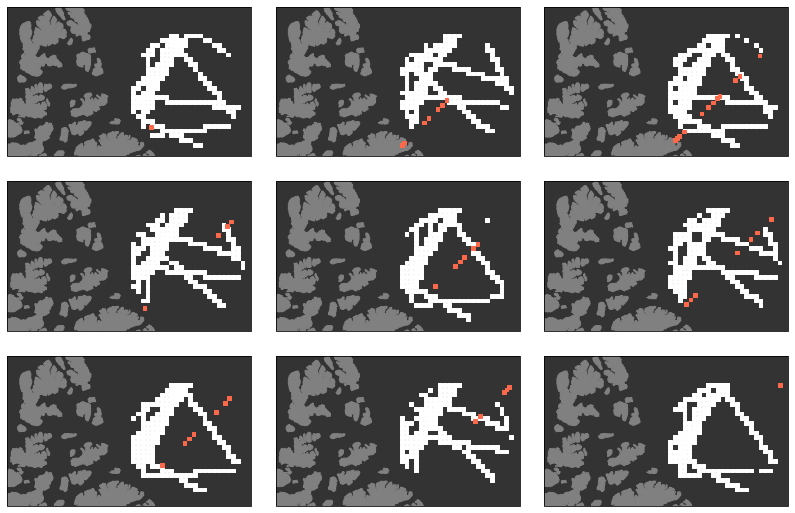

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

Kxsx = np.ones((len(X),len(Xs)))
dayIDs = []
for day in range(9):
    dayIDs.append(np.where(inputs[:,2]==day))

fig,ax = plt.subplots(3,3,figsize=(14,10),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
xx = [inputs[:,0][dayIDs[0]],inputs[:,0][dayIDs[1]],inputs[:,0][dayIDs[2]],inputs[:,0][dayIDs[3]],inputs[:,0][dayIDs[4]],\
    inputs[:,0][dayIDs[5]],inputs[:,0][dayIDs[6]],inputs[:,0][dayIDs[7]],inputs[:,0][dayIDs[8]]]
yy = [inputs[:,1][dayIDs[0]],inputs[:,1][dayIDs[1]],inputs[:,1][dayIDs[2]],inputs[:,1][dayIDs[3]],inputs[:,1][dayIDs[4]],\
    inputs[:,1][dayIDs[5]],inputs[:,1][dayIDs[6]],inputs[:,1][dayIDs[7]],inputs[:,1][dayIDs[8]]]
zz = [Kxsx[dayIDs[0]],Kxsx[dayIDs[1]],Kxsx[dayIDs[2]],Kxsx[dayIDs[3]],Kxsx[dayIDs[4]],\
    Kxsx[dayIDs[5]],Kxsx[dayIDs[6]],Kxsx[dayIDs[7]],Kxsx[dayIDs[8]]]
k = 0
text = ['$t - 4$','$t - 3$','$t - 2$','$t - 1$','$t$','$t + 1$','$t + 2$','$t + 3$','$t + 4$']
for ax1 in range(3):
    for ax2 in range(3):
        #lonc,latc = mplot(.94e6,3.5e5,inverse=True)
        #circle = plt.Circle((.94e6,3.5e5),300e3,color='k',fill=False,linewidth=4)
        ax[ax1,ax2].set_extent([-118,-90,75,86],ccrs.PlateCarree())
        ax[ax1,ax2].add_feature(cfeat.OCEAN,color=(0.2,0.2,0.2))
        ax[ax1,ax2].add_feature(cfeat.LAKES,color=(0.2, 0.2, 0.2))
        ax[ax1,ax2].add_feature(cfeat.RIVERS,color=(0.2, 0.2, 0.2))
        ax[ax1,ax2].add_feature(cfeat.LAND,color=(0.5,0.5,0.5))
        lonxx,latxx = mplot(xx[k],yy[k],inverse=True)
        IDZ = Z[:,2]==k
        s = ax[ax1,ax2].scatter(lonxx,latxx,c=zz[k].ravel()*100,vmin=0,vmax=1,cmap='Greys_r',marker='s',s=14,\
                               transform=ccrs.PlateCarree())
        if ((IDZ).any()):
            lonZ,latZ = mplot(Z[IDZ,0],Z[IDZ,1],inverse=True)
            ax[ax1,ax2].scatter(lonZ,latZ,c=np.ones(len(lonZ)),vmin=0,vmax=2,cmap='Reds',marker='s',s=14,\
                               transform=ccrs.PlateCarree())
        #ax[ax1,ax2].add_artist(circle)
        k += 1
plt.subplots_adjust(wspace=.1,hspace=-0.1)
plt.show()